
# FASTSim Demonstration

![fastsim icon](icon_fastsim.jpg)

Developed by NREL, the Future Automotive Systems Technology Simulator (FASTSim) evaluates the impact of technology improvements on efficiency, performance, cost, and battery life in conventional vehicles, hybrid electric vehicles (HEVs), plug-in hybrid electric vehicles (PHEVs), and all-electric vehicles (EVs).

FASTSim answers questions such as:
- Which battery sizes are most cost effective for a PHEV or EV?
- At what battery prices do PHEVs and EVs become cost effective?
- On average, how much fuel does a PHEV with a 30-mile electric range save?
- How much fuel savings does an HEV provide for a given drive cycle?
- How do lifetime costs and petroleum use compare for conventional vehicles, HEVs, PHEVs, and EVs?

FASTSim was originally implemented in Microsoft Excel. The pythonic implementation of FASTSim, demonstrated here, captures the drive cycle energy consumption simulation component of the software. The python version of FASTSim is more convenient than the Excel version when very high computational speed is desired, such as for simulating a large batch of drive cycles.

In [500]:
import sys
import os
from pathlib import Path
# allow it to find simdrive module
fsimpath=str(Path(os.getcwd()).parents[0])
if fsimpath not in sys.path:
    sys.path.append(fsimpath)
import numpy as np
from scipy.integrate import cumtrapz
import time
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import importlib
import math
# import seaborn as sns
# sns.set(font_scale=2, style='whitegrid')

%matplotlib inline

In [2]:
# local modules
from fastsim import simdrive, vehicle, cycle
from fastsim import globalvars as gl
# importlib.reload(simdrive)
# importlib.reload(cycle)

## Individual Drive Cycle
### Load Drive Cycle

Default (UDDS, US06, HWFET) cycles can be loaded from the ```../cycles``` directory, or custom cycles can be specified in the same format. The expected format is a dictionary with the following keys: 
```['cycSecs', 'cycMps']``` at minimum, or optionally:  
```['cycSecs', 'cycMps', 'cycGrade', 'cycRoadType']```
- cycGrade = Road grade [%/100]
- cycMps = Vehicle speed [meters per second]
- cycSecs = Relative time in the cycles [seconds]
- cycRoadType = Indicator as to whether or not there is a wireless charging capability from the road to vehicle

There is no limit to the length of a drive cycle that can be provided as an input to FASTSim.

In [3]:
t0 = time.time()
cyc = cycle.Cycle("udds")
cyc_jit = cyc.get_numba_cyc()
print(time.time() - t0)

2.0006511211395264


### Load Powertrain Model

A vehicle database in CSV format is required to be in the working directory where FASTSim is running (i.e. the same directory as this notebook). The "get_veh" function selects the appropriate vehicle attributes from the database and contructs the powertrain model (engine efficiency map, etc.). An integer value corresponds to each vehicle in the database. To add a new vehicle, simply populate a new row to the vehicle database CSV.

In [4]:
t0 = time.time()
veh = vehicle.Vehicle(veh_file='../vehdb/Class 4 Truck.csv')
veh_jit = veh.get_numba_veh()
print(time.time() - t0)

21.159427642822266


### Run FASTSim

The "sim_drive" function takes the drive cycle and vehicle models defined above as inputs. The output is a dictionary of time series and scalar values described the simulation results. Typically of interest is the "gge" key, which is an array of time series energy consumption data at each time step in the drive cycle.

If running FASTSim in batch over many drive cycles, the output from "sim_drive" can be written to files or database for batch post-processing. 

In [5]:
t0 = time.time()

sim_drive_params = simdrive.SimDriveParams(missed_trace_correction=True)
# veh_jit.vehKg = 15e3
sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit, sim_drive_params)
# sim_drive = simdrive.SimDriveClassic(cyc_jit, veh_jit, sim_drive_params)

sim_drive.sim_drive() 

print(time.time() - t0)

121.6178412437439


### Drive cycle results 
with time trace miss correction

Text(0, 0.5, 'Speed [mps]')

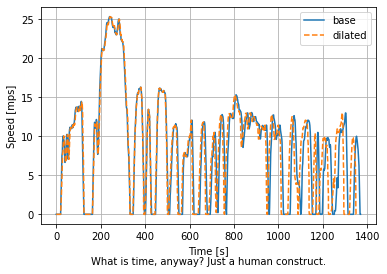

In [6]:
plt.plot(cyc.cycSecs, cyc.cycMps, label='base')
plt.plot(sim_drive.cyc.cycSecs, sim_drive.mpsAch, label='dilated', linestyle = '--')
plt.grid()
plt.legend()
plt.xlabel('Time [s]\nWhat is time, anyway? Just a human construct.')
plt.ylabel('Speed [mps]')

Text(0, 0.5, 'Speed [mps]')

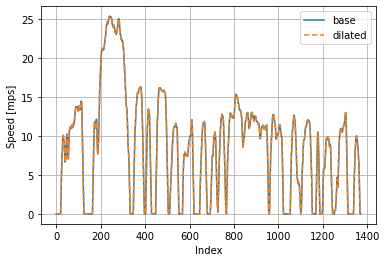

In [7]:
plt.plot(cyc.cycMps, label='base')
plt.plot(sim_drive.mpsAch, label='dilated', linestyle = '--')
plt.grid()
plt.legend()
plt.xlabel('Index')
plt.ylabel('Speed [mps]')

Text(0, 0.5, 'Distance [m]')

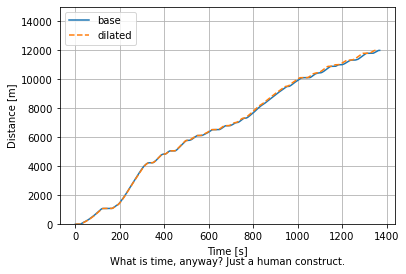

In [8]:
plt.plot(cyc.cycSecs, (cyc.cycMps * cyc.secs).cumsum(), label='base')
plt.plot(sim_drive.cyc.cycSecs, (sim_drive.mpsAch * sim_drive.cyc.secs).cumsum()
         , label='dilated', linestyle = '--')
plt.grid()
plt.legend(loc='upper left')
plt.ylim(0, 15000)
plt.xlabel('Time [s]\nWhat is time, anyway? Just a human construct.')
plt.ylabel('Distance [m]')

Text(0, 0.5, 'Distance [m]')

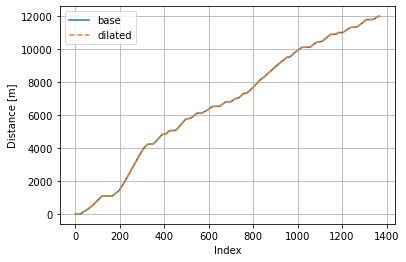

In [9]:
plt.plot((cyc.cycMps * cyc.secs).cumsum(), label='base')
plt.plot((sim_drive.mpsAch * sim_drive.cyc.secs).cumsum()
         , label='dilated', linestyle = '--')
plt.grid()
plt.legend(loc='upper left')
plt.xlabel('Index')
plt.ylabel('Distance [m]')

### Coastdown validation/tuning

In [10]:
# get the data
raw_df = pd.read_csv(r'C:\Users\cbaker2\Documents\Projects\FASTSim'+
                     '\MDHD\Isuzu NPR HD Boxtruck coastdown.csv', header=None)
raw_df.columns = ['Time [s]', 'Speed [mph]']

In [11]:
# split it up into the two separate curves for each cd direction
north_cut = np.argmax(raw_df.iloc[1:, 0].values < raw_df.iloc[:-1, 0].values)
north_df = raw_df.iloc[:north_cut]
south_df = raw_df.iloc[north_cut+1:]

In [12]:
# polynomial fit
p_coeffs_n = np.polyfit(north_df['Time [s]'], north_df['Speed [mph]'], 3)
poly_n = np.poly1d(p_coeffs_n)
p_coeffs_s = np.polyfit(south_df['Time [s]'], south_df['Speed [mph]'], 3)
poly_s = np.poly1d(p_coeffs_s)

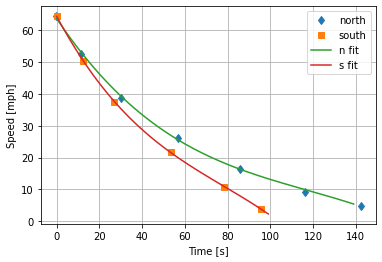

In [13]:
ax = north_df.plot(x='Time [s]', y='Speed [mph]', label='north', linestyle='', marker='d')
south_df.plot(x='Time [s]', y='Speed [mph]', ax=ax, label='south', linestyle='', marker='s')
plt.plot(np.arange(140), poly_n(np.arange(140)), label='n fit')
plt.plot(np.arange(100), poly_s(np.arange(100)), label='s fit')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Speed [mph]')
plt.grid()

### Checking northbound coastdown match

In [14]:
cyc_n = cycle.Cycle(cyc_dict=
        {'cycSecs':np.arange(140), 'cycMps':poly_n(np.arange(140)) / gl.mphPerMps, 
        'cycGrade':np.ones(140) * -0.4 / 100})
cyc_n_jit = cyc_n.get_numba_cyc()

veh = vehicle.Vehicle(veh_file='../vehdb/Class 4 Truck.csv')
veh_jit = veh.get_numba_veh()

simdrive_n = simdrive.SimDriveJit(cyc_n_jit, veh_jit)
simdrive_n.mpsAch[0] = cyc_n.cycMps[0]
simdrive_n.sim_drive()

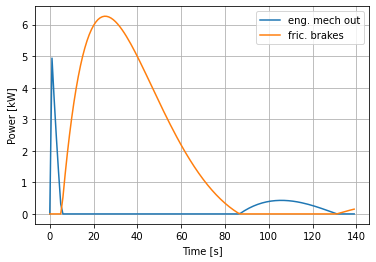

In [15]:
plt.figure()
plt.plot(cyc_n.cycSecs, simdrive_n.fcKwOutAch, label='eng. mech out')
plt.plot(cyc_n.cycSecs, simdrive_n.cycFricBrakeKw, label='fric. brakes')
plt.xlabel('Time [s]')
plt.ylabel('Power [kW]')
plt.legend()
plt.grid()

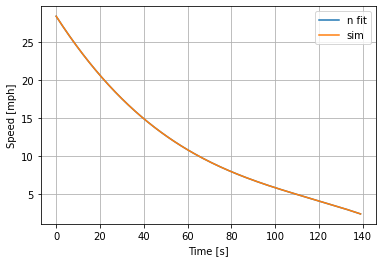

In [16]:
plt.plot(np.arange(140), poly_n(np.arange(140)) / gl.mphPerMps, label='n fit')
plt.plot(cyc_n.cycSecs, simdrive_n.mpsAch, label='sim')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Speed [mph]')
plt.grid()

### Checking southbound coastdown match

In [17]:
cyc_s = cycle.Cycle(cyc_dict=
        {'cycSecs':np.arange(100), 'cycMps':poly_s(np.arange(100)) / gl.mphPerMps, 
        'cycGrade':np.ones(100) * 0.4 / 100})
cyc_s_jit = cyc_s.get_numba_cyc()

veh = vehicle.Vehicle(veh_file='../vehdb/Class 4 Truck.csv')
veh_jit = veh.get_numba_veh()
simdrive_s = simdrive.SimDriveJit(cyc_s_jit, veh_jit)
simdrive_s.mpsAch[0] = cyc_s.cycMps[0]
simdrive_s.sim_drive()

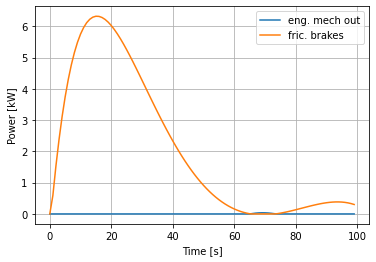

In [18]:
plt.figure()
plt.plot(cyc_s.cycSecs, simdrive_s.fcKwOutAch, label='eng. mech out')
plt.plot(cyc_s.cycSecs, simdrive_s.cycFricBrakeKw, label='fric. brakes')
plt.xlabel('Time [s]')
plt.ylabel('Power [kW]')
plt.legend()
plt.grid()

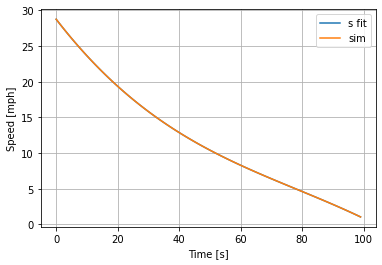

In [19]:
plt.plot(np.arange(100), poly_s(np.arange(100)) / gl.mphPerMps, label='s fit')
plt.plot(cyc_s.cycSecs, simdrive_s.mpsAch, label='sim')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Speed [mph]')
plt.grid()

## Validating Against Test Data
Reasonable weight range for class 4: (6,351–7,257 kg)

In [290]:
# functions for things that will be done repeatedly
def rollav(data, width):
    out = np.zeros(len(data))
    for i in range(len(data)):
        if i < width:
            out[i] = data[:i].mean()
        else:
            out[i] = data[i-width:i].mean()
    return out

def plot_speed(sd, df, ax2):
    ax2.plot(sd.cyc.cycSecs, sd.mphAch, label='FASTSim')
    ax2.plot(sd.cyc.cycSecs, df['Speed[mps]'] * 2.2, label='test', linestyle='--', alpha=0.75)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Speed [mph]')
    ax2.legend()
    ax2.grid()

def plot_fuel_power(sd, df, save_name='', roll_width=10):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(sd.cyc.cycSecs, rollav(sd.fcKwInAch, roll_width), label='FASTSim')
    ax1.plot(sd.cyc.cycSecs, df['Fuel Power [kW]'], label='test')
    # ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Fuel Power [kW]')
    ax1.legend()
    ax1.grid()
    
    plot_speed(sd, df, ax2)

    fig.savefig(save_name + ' fuel kW.png')
    
def plot_fuel_energy(sd, df, save_name=''):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(sd.cyc.cycSecs[1:], cumtrapz(y=sd.fcKwInAch / 1e3, x=sd.cyc.cycSecs),
             label='FASTSim')
    ax1.plot(sd.cyc.cycSecs[1:], cumtrapz(y=df['Fuel Power [kW]'] / 1e3, x=df['time[s]']),
             label='test')
    # ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Fuel Energy [MJ]')
    ax1.legend()
    ax1.grid()
    
    plot_speed(sd, df, ax2)
    
    fig.savefig(save_name + ' fuel MJ.png')

def plot_eng_power(sd, df, save_name='', roll_width=10):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(sd.cyc.cycSecs, rollav(sd.fcKwOutAch, roll_width), label='FASTSim')
    ax1.plot(sd.cyc.cycSecs, df['Eng Power [kW]'], label='test')
    # ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Eng Power [kW]')
    ax1.legend()
    ax1.grid()
    
    plot_speed(sd, df, ax2)

    fig.savefig(save_name + ' eng kW.png')
    
def plot_eng_energy(sd, df, save_name=''):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(sd.cyc.cycSecs[1:], cumtrapz(y=sd.fcKwOutAch / 1e3, x=sd.cyc.cycSecs),
             label='FASTSim')
    ax1.plot(sd.cyc.cycSecs[1:], cumtrapz(y=df['Eng Power [kW]'] / 1e3, x=df['time[s]']),
             label='test')
    # ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Cumulative\n' + 'Eng Energy [MJ]')
    ax1.legend()
    ax1.grid()
    
    plot_speed(sd, df, ax2)
    
    fig.savefig(save_name + ' eng MJ.png')
    
# constants
rho_diesel = 0.832 # https://en.wikipedia.org/wiki/Diesel_fuel
lhv_diesel = 42.6e3 # [kJ/kg] https://www.engineeringtoolbox.com/fuels-higher-calorific-values-d_169.html

Y:\5400\ReFUEL\Projects\1 Archived Projects\2015_Carb Aero\Data\on-road\Isuzu\test.csv

In [291]:
df_isuzu = pd.read_csv('../cycles/Isuzu_test_formatted.csv')
df_isuzu['Fuel Power [kW]'] = df_isuzu['EngFuelRate[l/h]'] / 3600 * rho_diesel * lhv_diesel
df_isuzu['Speed[mps]'] = df_isuzu['gps_Speed[km/h]'].values * 0.278
df_isuzu['Eng Torque [N*m]'] = df_isuzu['EngReferenceTorque[-]'] * df_isuzu['EngPercentTorque_ACT[%]'] / 100
df_isuzu['Eng Power [kW]'] = df_isuzu['Eng Torque [N*m]'] * df_isuzu['EngSpeed[RPM]'] / 60 * 2 * np.pi / 1e3
df_isuzu['Eng Eff [-]'] = df_isuzu['Eng Power [kW]'] / df_isuzu['Fuel Power [kW]']

In [292]:
cyc_isuzu = cycle.Cycle(
    cyc_dict={'cycSecs':df_isuzu['time[s]'].values, 
              'cycMps':df_isuzu['Speed[mps]'].values})\
    .get_numba_cyc()
veh = vehicle.Vehicle(veh_file='../vehdb/Class 4 Truck.csv')
# veh.dragCoef = 0.1
# veh.vehKg = 4500
veh_jit = veh.get_numba_veh()

sd_isuzu = simdrive.SimDriveJit(cyc_isuzu, veh_jit)
sd_isuzu.sim_drive()

In [293]:
print('Total fuel in test: {:.3f} MJ'.format(
    np.trapz(df_isuzu['Eng Power [kW]'], df_isuzu['time[s]']) / 1e3))
print('Total fuel in FASTSim: {:.3f} MJ'.format(np.trapz(sd_isuzu.fcKwOutAch / 1e3, cyc_isuzu.cycSecs)))

Total fuel in test: 5.154 MJ
Total fuel in FASTSim: 7.996 MJ


In [294]:
print('Total fuel in test: {:.3f} MJ'.format(
    np.trapz(df_isuzu['Fuel Power [kW]'], df_isuzu['time[s]']) / 1e3))
print('Total fuel in FASTSim: {:.3f} MJ'.format(np.trapz(sd_isuzu.fcKwInAch / 1e3, cyc_isuzu.cycSecs)))

Total fuel in test: 16.067 MJ
Total fuel in FASTSim: 26.170 MJ


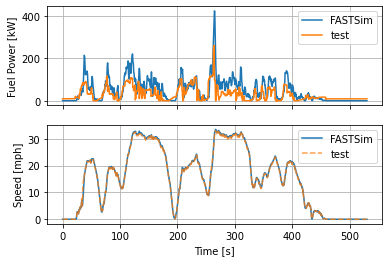

In [295]:
plot_fuel_power(sd_isuzu, df_isuzu, save_name='fastim vs isuzu test', roll_width=10)

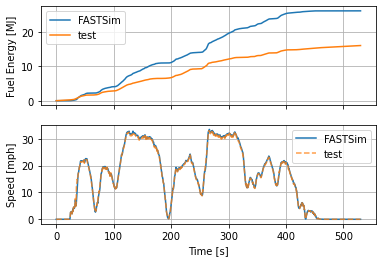

In [296]:
plot_fuel_energy(sd_isuzu, df_isuzu, save_name='fastim vs isuzu test')

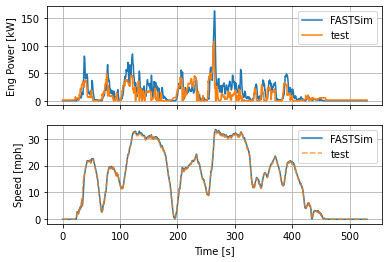

In [297]:
plot_eng_power(sd_isuzu, df_isuzu, save_name='fastim vs isuzu test', roll_width=10)

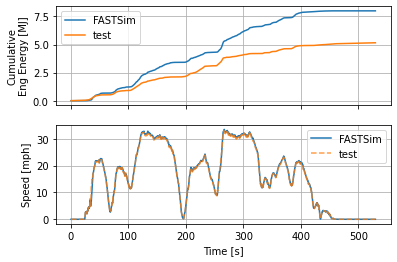

In [298]:
plot_eng_energy(sd_isuzu, df_isuzu, save_name='fastim vs isuzu test')

Y:\5400\ADV_VEH_INFRA\Fleet Test and Evaluation\Projects\2017 CARB Voc Aero\Data\A1_Truck_Rental\I17_CARB-Aero_Rental_5P36767

In [ ]:
# function for loading data from Y drive

In [520]:
topdir = r'Y:\5400\ADV_VEH_INFRA\Fleet Test and Evaluation\Projects\2017 CARB Voc Aero\Data'
# datadir = topdir + r'\A1_Truck_Rental\I17_CARB-Aero_Rental_5P36767' # no fuel flow
# datadir = topdir + r'\Dy_Dee_Laudry_Service\I11_CARB-Aero_Laundry_Service_60007M2' # no fuel flow
# datadir = topdir + r'\Coachella_Valley_Water_District\I7_CARB-Aero_Work_Truck_2400' # no fuel flow
# datadir = topdir + r'\Coachella_Valley_Water_District\I20_CARB-Aero_Work_Truck_2437'  # no fuel flow
datadir = topdir + r'\TeeVax\I18_CARB-Aero_Appliance Delivery_104'

files = [file for file in 
         os.listdir(datadir) 
         if 'SEGMENT' in file]

with open(datadir + '\\' + files[0], 'r') as file:
    data = file.readlines()
    data0list = data[0].split(',')
    data1list = data[1].split(',')
    
    header = ''
    for i, (d0, d1) in enumerate(zip(data0list, data1list)):
        header += d0 + ' [' + d1 + '],'
    header.replace('\n', '')
    header = header[:-1]
    columns = header.split(',')
    

data2d = []
last_segment = len(files) // 2
print_prog = [10] # greater than zero triggers print at start
for i in range(last_segment):
    print_prog.append(np.floor(i / last_segment * 100) % 20)
    if print_prog[-1] < print_prog[-2]:
        print('{:.0%} complete loading'.format(i / last_segment))
        print(f'Loading data from {files[i]}')
    with open(datadir + '\\' + files[i], 'r') as file:
        data = file.readlines()
        for i, row in enumerate(data[5:]):
            data2d.append(row.replace('\n', '').split(','))

20% complete loading
Loading data from I18_CARB-Aero_Appliance Delivery_104_SEGMENT020.csv
40% complete loading
Loading data from I18_CARB-Aero_Appliance Delivery_104_SEGMENT040.csv
61% complete loading
Loading data from I18_CARB-Aero_Appliance Delivery_104_SEGMENT060.csv
81% complete loading
Loading data from I18_CARB-Aero_Appliance Delivery_104_SEGMENT080.csv


In [521]:
df = pd.DataFrame(data2d, columns=columns)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

In [522]:
df['Speed [mph]'] = df['gps_Speed [km/h]'] / 1.61
df['Fuel Power [kW]'] = df['EngFuelRate [l/h]'] / 3600 * rho_diesel * lhv_diesel
df['Speed[mps]'] = df['gps_Speed [km/h]'].values * 0.278
df['time[s]'] = df['time [s]']

In [523]:
time_jumps = np.where(df['time [s]'].values[1:] < df['time [s]'].values[:-1])[0]
max_good_time_start = time_jumps[np.argmax(np.diff(time_jumps))] + 1
max_good_time_end = time_jumps[np.argmax(np.diff(time_jumps)) + 1]
         
df = df.iloc[max_good_time_start:max_good_time_end]
df.reset_index(inplace=True, drop=True)

In [555]:
cyc_cust = cycle.Cycle(
    cyc_dict={'cycSecs':df['time[s]'].values, 
              'cycMps':df['Speed[mps]'].values})\
    .get_numba_cyc()
veh = vehicle.Vehicle(veh_file='../vehdb/Class 4 Truck.csv')
veh.dragCoef = 0.35
veh.wheelRrCoef = 0.005
veh.vehKg = 6351
veh.auxKw = 2
veh_jit = veh.get_numba_veh()

sd_cust = simdrive.SimDriveJit(cyc_cust, veh_jit)
sd_cust.sim_drive()

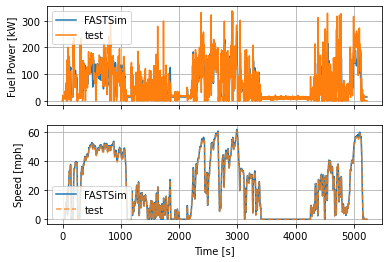

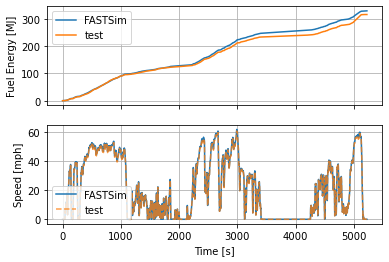

In [556]:
plot_fuel_power(sd_cust, df, 'thinger')
plot_fuel_energy(sd_cust, df, 'thinger')